In [33]:
import yt
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import numpy as np

In [60]:
yt.funcs.mylog.setLevel(50)

FVS_path = '/home/maikel/Development/FiniteVolumeSolver'
extra_path = '{}/extra'.format(FVS_path)

level_integrator_path = '{}/build_2D-Debug/TravellingVortex_old/Debug'.format(FVS_path)
solver_path = '{}/build_2D-Debug/TravellingVortex/Debug'.format(FVS_path)

#level_integrator_path = '{}/build_2D-Debug/TravellingVortex_old/Plotfiles'.format(FVS_path)
#solver_path = '{}/build_2D-Debug/TravellingVortex/Plotfiles'.format(FVS_path)


def LoadFVS(base_dir, step_dir, partname, timestep):
  path = os.path.join(base_dir, step_dir, partname+'plt{:09d}'.format(timestep))
  shutil.copy2('{}/yt/WarpXHeader'.format(extra_path), path)
  shutil.copy2('{}/yt/warpx_job_info'.format(extra_path), path)
  return yt.load(path)

substeps = [
    'BK19_pre-step',
    'BK19_advect',
    'BK19_advect-backward',
    'BK19_advect-backward-forward',
    'BK19_advect-backward-forward-advect',
    'BK19_advect-backward-forward-advect-backward'
]


In [66]:
def CompareField(dataset1, dataset2, field, abs_tolerance=1e-8):
    if (dataset1.domain_dimensions != dataset2.domain_dimensions).all():
        return False
    dims = dataset1.domain_dimensions

    p1 = yt.SlicePlot(dataset1, 'z', field)
    p1.set_buff_size([dims[0], dims[1]])
    field1 = np.array(p1.frb[field])
    
    p2 = yt.SlicePlot(dataset2, 'z', field)
    p2.set_buff_size([dims[0], dims[1]])
    field2 = np.array(p2.frb[field])

    dField = field2 - field1
    d_norm = np.linalg.norm(dField, np.inf)
    print("{}:".format(field))
    figs, axs = plt.subplots(1, 3)
    axs[0].imshow(field1, origin='lower')
    axs[1].imshow(field2, origin='lower')
    axs[2].imshow(dField, origin='lower')
    plt.show()
    if d_norm > abs_tolerance:
        print("Error norm for field variable '{}' is too large: {}".format(field, d_norm))
        print(dField)
        return False
    return True

def CompareMultipleFields(ds1, ds2, fields):
    comparisons = [CompareField(ds1, ds2, field) for field in fields]
    return all(comparisons)
    

fields = {
    '': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse"],
    'BK19_pre-step': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "pi_nd2cellavg"],
    'BK19_advect': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "pi_nd2cellavg"],
    'BK19_advect-backward': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "Momentum_corr0", "Momentum_corr1", "alpha_nd2cellavg", "pi_nd2cellavg", "solution_nd2cellavg", "sigma"],
    'BK19_advect-backward-forward': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "div_Pv_nd2cellavg", "pi_nd2cellavg", "Momentum_corr0", "Momentum_corr1", "Pi_correction_nd2cellavg", "Pu", "Pv"],
    'BK19_advect-backward-forward-advect': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "pi_nd2cellavg", "Pu", "Pv"],
    'BK19_advect-backward-forward-advect-backward': ["Density", "Momentum_0", "Momentum_1", "PTdensity", "PTinverse", "Momentum_corr0", "Momentum_corr1", "alpha_nd2cellavg", "pi_nd2cellavg", "solution_nd2cellavg", "sigma"],
}

def CompareSubstep(substep, timestep, partition='partition_0_'):
    ds1 = LoadFVS(level_integrator_path, substep, 'partition_0_', timestep)
    ds2 = LoadFVS(solver_path, substep, 'partition_0_', timestep)
    return CompareMultipleFields(ds1, ds2, fields[substep])

Density:


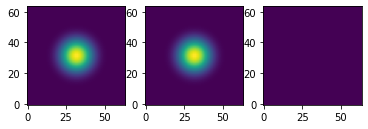

Momentum_0:


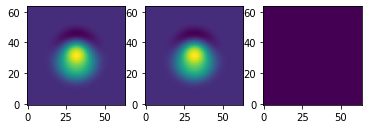

Momentum_1:


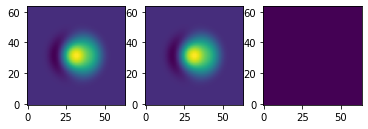

PTdensity:


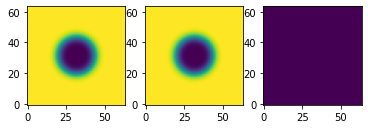

PTinverse:


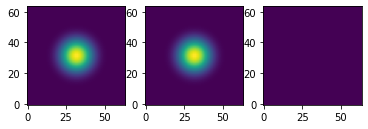

pi_nd2cellavg:


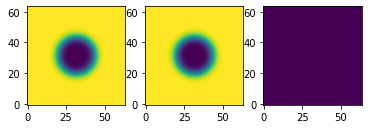

Density:


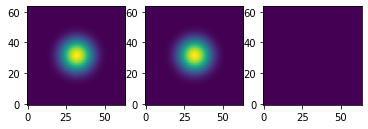

Momentum_0:


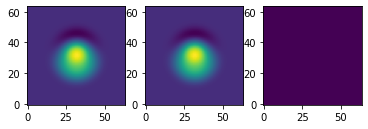

Momentum_1:


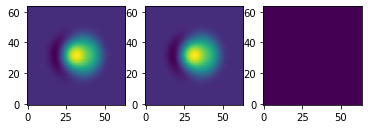

PTdensity:


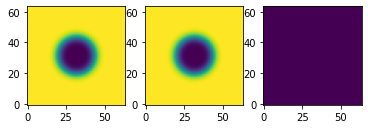

PTinverse:


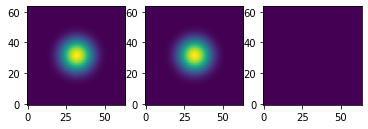

pi_nd2cellavg:


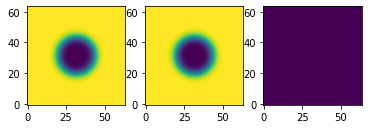

Density:


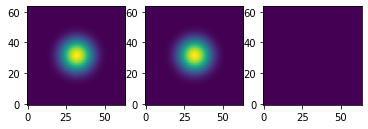

Momentum_0:


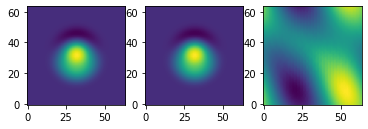

Momentum_1:


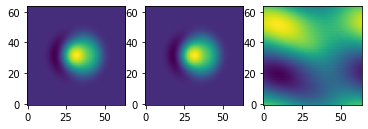

PTdensity:


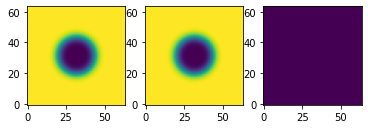

PTinverse:


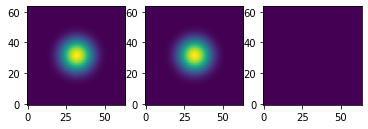

Momentum_corr0:


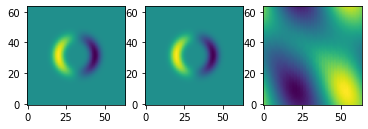

Momentum_corr1:


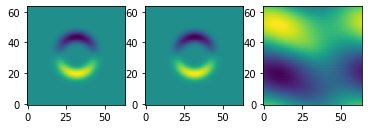

alpha_nd2cellavg:


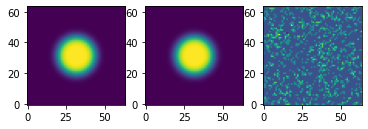

pi_nd2cellavg:


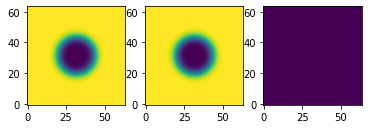

solution_nd2cellavg:


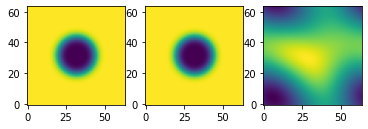

Error norm for field variable 'solution_nd2cellavg' is too large: 9.36848049140434e-09
[[-1.79155283e-10 -1.81880640e-10 -1.84247858e-10 ... -1.69091006e-10
  -1.72721150e-10 -1.76092126e-10]
 [-1.81714234e-10 -1.84420029e-10 -1.86754230e-10 ... -1.71590978e-10
  -1.75258373e-10 -1.78651622e-10]
 [-1.83750063e-10 -1.86408517e-10 -1.88678270e-10 ... -1.73625641e-10
  -1.77314008e-10 -1.80704501e-10]
 ...
 [-1.68527348e-10 -1.71198820e-10 -1.73564048e-10 ... -1.58944970e-10
  -1.62369109e-10 -1.65576860e-10]
 [-1.72526927e-10 -1.75225665e-10 -1.77607933e-10 ... -1.62725111e-10
  -1.66230583e-10 -1.69514222e-10]
 [-1.76085183e-10 -1.78800932e-10 -1.81180885e-10 ... -1.66128163e-10
  -1.69701391e-10 -1.73034777e-10]]
sigma:


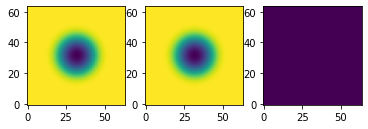

Failed to compare substep 'BK19_advect-backward'.


In [67]:
for substep in substeps:
    if not CompareSubstep(substep, 1):
        print("Failed to compare substep '{}'.".format(substep))
        break